# Madrid Real Estate - Linear Regression Project

## MDB 2018 - O2 - H

#### First we import libraries we will need

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
import time

#### We then import the data that was cleaned using Dataiku as per the attached document

In [3]:
df = pd.read_csv("./Data/idealista_data_V2_prepared.csv")

In [4]:
df.head() #We check the head of the dataframe to make sure everything seems ok

,address,bathrooms,country,detailedType_typology,detailedType_subTypology,distance,district,exterior,externalReference,floor,...,province,rooms,showAddress,size,status,suggestedTexts_subtitle,suggestedTexts_title,thumbnail,url,geopoint
0,"calle de San Restituto, 14",1,es,flat,NaN,5370,Moncloa,True,NaN,3,...,Madrid,1,True,42.0,good,"Valdezarza, Madrid","Piso en calle de San Restituto, 14",https://img3.idealista.com/blur/WEB_LISTING/0/...,https://www.idealista.com/inmueble/39665037/,POINT(-3.7107396 40.4646941)
1,saliente,4,es,chalet,independantHouse,12096,Urbanizaciones,False,NaN,0,...,Madrid,4,False,375.0,good,"Montealina, Pozuelo de Alarcón",Casa independiente en saliente,https://img3.idealista.com/blur/WEB_LISTING/0/...,https://www.idealista.com/inmueble/82149948/,POINT(-3.8454306 40.4330817)
2,"calle Mallorca, 3",1,es,flat,NaN,1192,Centro,True,NaN,0,...,Madrid,3,True,70.0,good,"Lavapiés-Embajadores, Madrid","Piso en calle Mallorca, 3",https://img3.idealista.com/blur/WEB_LISTING/0/...,https://www.idealista.com/inmueble/37138962/,POINT(-3.697682 40.4071354)
3,"calle Valmojado, 181",3,es,flat,NaN,5422,Latina,True,NaN,5,...,Madrid,3,True,79.0,good,"Aluche, Madrid","Piso en calle Valmojado, 181",https://img3.idealista.com/blur/WEB_LISTING/0/...,https://www.idealista.com/inmueble/83311256/,POINT(-3.7577512 40.3899565)
4,"avenida donostiarra, 21",2,es,flat,NaN,4326,Ciudad Lineal,True,NaN,11,...,Madrid,2,True,65.0,good,"Concepción, Madrid","Piso en avenida donostiarra, 21",https://img3.idealista.com/blur/WEB_LISTING/0/...,https://www.idealista.com/inmueble/31436202/,POINT(-3.6587854 40.4345648)


In [5]:
df.info() #We can see

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4148 entries, 0 to 4147
Data columns (total 39 columns):
address                     4148 non-null object
bathrooms                   4148 non-null int64
country                     4148 non-null object
detailedType_typology       4148 non-null object
detailedType_subTypology    716 non-null object
distance                    4148 non-null int64
district                    4148 non-null object
exterior                    4148 non-null bool
externalReference           2805 non-null object
floor                       4148 non-null int64
has360                      4148 non-null bool
has3DTour                   4148 non-null bool
hasLift                     4148 non-null bool
hasPlan                     4148 non-null bool
hasVideo                    4148 non-null bool
latitude                    4148 non-null float64
longitude                   4148 non-null float64
municipality                4148 non-null object
neighborhood             

We can see that there are a lot of categorical variables. These won't be the best for our regression project  
so we need to check how many unique categories and how broad they are.

In [6]:
for col in df.columns:
    if df[col].dtype == 'O':
        print(col ,'------', df[col].dtype == 'O')
        print(df[col].nunique())
        print("========================")

address ------ True
2580
country ------ True
1
detailedType_typology ------ True
2
detailedType_subTypology ------ True
6
district ------ True
67
externalReference ------ True
2548
municipality ------ True
13
neighborhood ------ True
162
operation ------ True
1
hasParkingSpace ------ True
1
parkingSpaceIncluded ------ True
2
propertyType ------ True
5
province ------ True
1
status ------ True
2
suggestedTexts_subtitle ------ True
191
suggestedTexts_title ------ True
2547
thumbnail ------ True
3931
url ------ True
3944
geopoint ------ True
3741


We can tell that most categorical variables might be too broad. Others are redundant (only 1 )  
So we will drop all columns that seem useless and build our regression from there

We need to check the categories that have only 1 to make sure that they are not T/F categories with NaN as flags

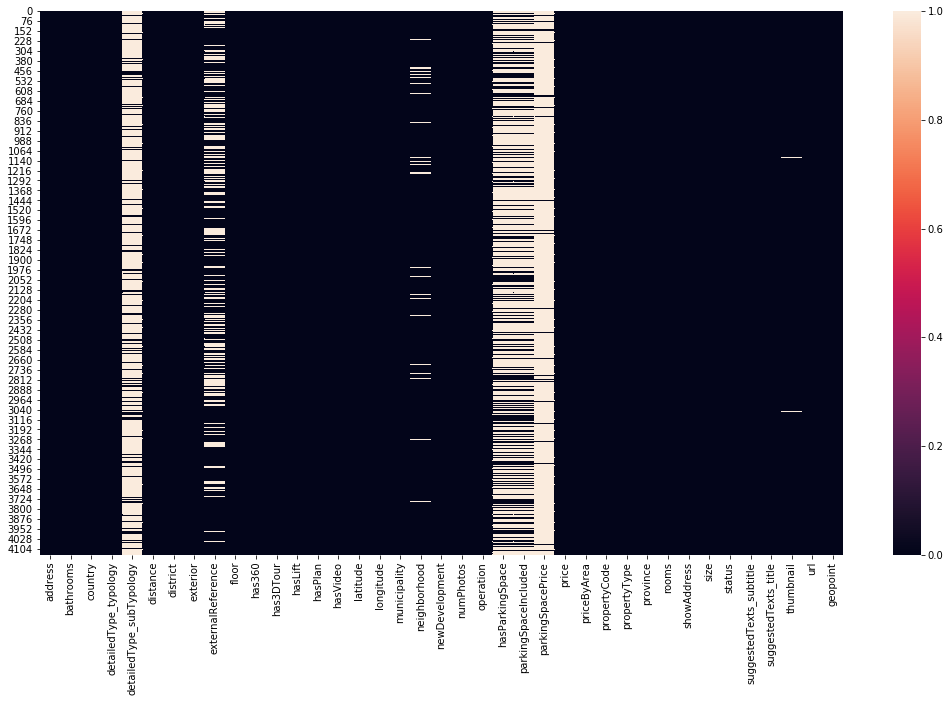

In [7]:
fig, ax = plt.subplots(figsize=(18,10))
sns.heatmap(df.isnull())

Seems like sub_Typology, externalReference, hasParkingSpace, parkingSpaceIncluded and parkingSpacePrice have a lot of nulls.  
The first 2 we might drop as they seem to be almost identifiers, has parking space we could try settin them to false.  
and drop the other 2 columns related to parking space

In [8]:
df['hasParkingSpace'].isnull().sum()/len(df['hasParkingSpace']) # 66% of the rows are null values, we take a risk using this 

0.6656219864995179

In [9]:
df['hasParkingSpace'].fillna(False, inplace=True) #We try imputing as parkins space seems important

In [10]:
col_drop = []
for col in df.columns:
    if df[col].dtype == 'O' and (df[col].nunique() == 1 or df[col].nunique() >100 or df[col].isnull().sum()/len(df[col]) > 0.5) :
        col_drop.append(col)

In [11]:
col_drop.append('parkingSpacePrice') #This column is almost completely empty
col_drop

['address',
 'country',
 'detailedType_subTypology',
 'externalReference',
 'neighborhood',
 'operation',
 'parkingSpaceIncluded',
 'province',
 'suggestedTexts_subtitle',
 'suggestedTexts_title',
 'thumbnail',
 'url',
 'geopoint',
 'parkingSpacePrice']

In [12]:
df.drop(col_drop, axis=1, inplace=True)

In [13]:
for col in df.columns:
    if df[col].dtype == 'O':
        print(col ,'------', df[col].dtype == 'O')
        print(df[col].nunique())
        print("========================")

detailedType_typology ------ True
2
district ------ True
67
municipality ------ True
13
propertyType ------ True
5
status ------ True
2


We this we take care of wrangling the categorical values

Now we check the rest for null values

In [14]:
df.isnull().any().any()

False

We are now ready to start exploring and finding our model features

In [25]:
for col in df.columns:
    if df[col].dtype == 'bool':
        print(col ,'------', df[col].dtype == 'bool')
        print(df[col].nunique())
        print("========================")

exterior ------ True
2
has360 ------ True
2
has3DTour ------ True
2
hasLift ------ True
2
hasPlan ------ True
2
hasVideo ------ True
2
newDevelopment ------ True
1
hasParkingSpace ------ True
2
showAddress ------ True
2


"newDevelopment" is a boolean variable with all Falses so we will also drop it

In [26]:
df.drop('newDevelopment', axis=1, inplace=True)

## Exploratory Data Analisys

In [27]:
df.describe()

,bathrooms,distance,floor,latitude,longitude,numPhotos,price,priceByArea,propertyCode,rooms,size
count,4148.000000,4148.000000,4148.000000,4148.000000,4148.000000,4148.000000,4148.000000,4148.000000,4.148000e+03,4148.000000,4148.000000
mean,1.706606,4496.768322,3.187801,40.435634,-3.692264,22.273867,1570.477097,16.433703,7.632915e+07,2.186837,104.701061
std,0.898776,3386.085864,2.772488,0.032076,0.043421,11.602292,813.890293,5.707456,1.815802e+07,1.188949,66.199236
min,1.000000,22.000000,-1.000000,40.301089,-3.880282,0.000000,400.000000,5.000000,3.021850e+05,0.000000,20.000000
25%,1.000000,1927.000000,1.000000,40.419253,-3.705716,14.000000,950.000000,13.000000,8.270398e+07,1.000000,60.000000
50%,2.000000,3418.000000,3.000000,40.432533,-3.690367,21.000000,1300.000000,15.000000,8.326503e+07,2.000000,87.000000
75%,2.000000,6500.000000,5.000000,40.456387,-3.673120,28.000000,1935.000000,19.000000,8.343392e+07,3.000000,127.000000
max,9.000000,14944.000000,25.000000,40.545903,-3.536303,94.000000,4000.000000,63.000000,8.346855e+07,9.000000,565.000000


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4148 entries, 0 to 4147
Data columns (total 24 columns):
bathrooms                4148 non-null int64
detailedType_typology    4148 non-null object
distance                 4148 non-null int64
district                 4148 non-null object
exterior                 4148 non-null bool
floor                    4148 non-null int64
has360                   4148 non-null bool
has3DTour                4148 non-null bool
hasLift                  4148 non-null bool
hasPlan                  4148 non-null bool
hasVideo                 4148 non-null bool
latitude                 4148 non-null float64
longitude                4148 non-null float64
municipality             4148 non-null object
numPhotos                4148 non-null int64
hasParkingSpace          4148 non-null bool
price                    4148 non-null float64
priceByArea              4148 non-null float64
propertyCode             4148 non-null float64
propertyType             4148 no

At a first glance, knowing about renting apartment. There should be a correlation between:  
Price and Size  
Price and rooms  
Price and district  
Price and having parking

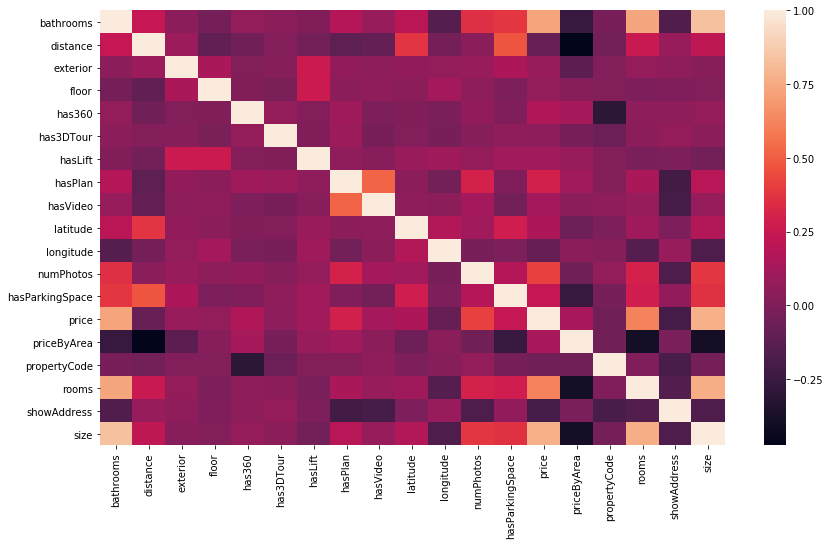

In [37]:
plt.subplots(figsize=(14,8))
sns.heatmap(df.corr())

In [35]:
df.corr()['price']

bathrooms          0.733046
distance          -0.078170
exterior           0.087460
floor              0.068430
has360             0.170783
has3DTour          0.053712
hasLift            0.113241
hasPlan            0.293408
hasVideo           0.128853
latitude           0.157629
longitude         -0.084138
numPhotos          0.413168
hasParkingSpace    0.236443
price              1.000000
priceByArea        0.138320
propertyCode      -0.051988
rooms              0.615577
showAddress       -0.204833
size               0.776695
Name: price, dtype: float64

Seems the highest correlations are with bathrooms, hasPlan, numPhotos, rooms and size  
This could be because the more expensive places tendo to have more work into them including more information  
to the platform. The size, rooms and bathrooms are logical correlations

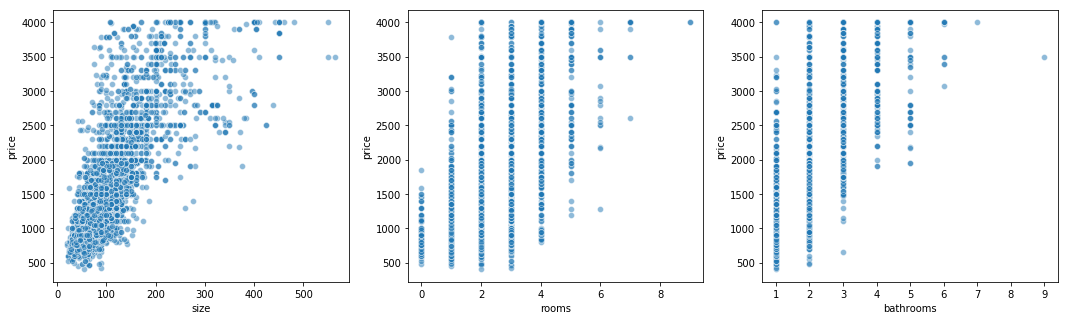

In [43]:
fig, ax = plt.subplots(1,3, figsize=(18,5))
sns.scatterplot(x='size', y='price', data=df, ax=ax[0], alpha=0.5)
sns.scatterplot(x='rooms', y='price', data=df, ax=ax[1], alpha=0.5)
sns.scatterplot(x='bathrooms', y='price', data=df, ax=ax[2], alpha=0.5)

[Text(0,0,'Madrid'),
 Text(0,0,'Pozuelo de Alarcón'),
 Text(0,0,'La Moraleja'),
 Text(0,0,'San Fernando de Henares'),
 Text(0,0,'Boadilla del Monte'),
 Text(0,0,'Majadahonda'),
 Text(0,0,'Alcorcón'),
 Text(0,0,'Getafe'),
 Text(0,0,'Leganés'),
 Text(0,0,'Alcobendas'),
 Text(0,0,'Rivas-Vaciamadrid'),
 Text(0,0,'Coslada'),
 Text(0,0,'Las Rozas de Madrid')]

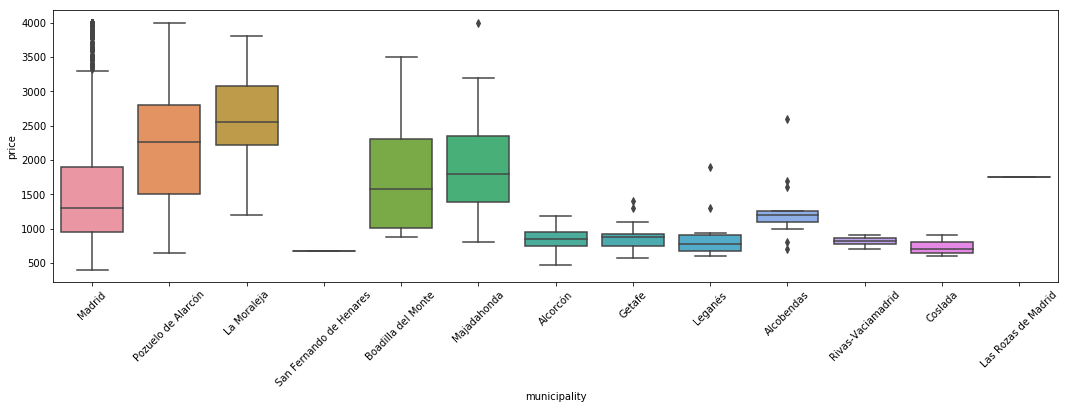

In [50]:
fig, ax = plt.subplots(figsize=(18,5))
g = sns.boxplot(x='municipality', y='price', data=df)
g.set_xticklabels(df['municipality'].unique(),rotation=45)

We can see that there seems to be a sizeable difference in price between the different municipalities

In [55]:
df['district'].nunique()

67

In [66]:
9 // 2

4

In [63]:
9 % 2

1

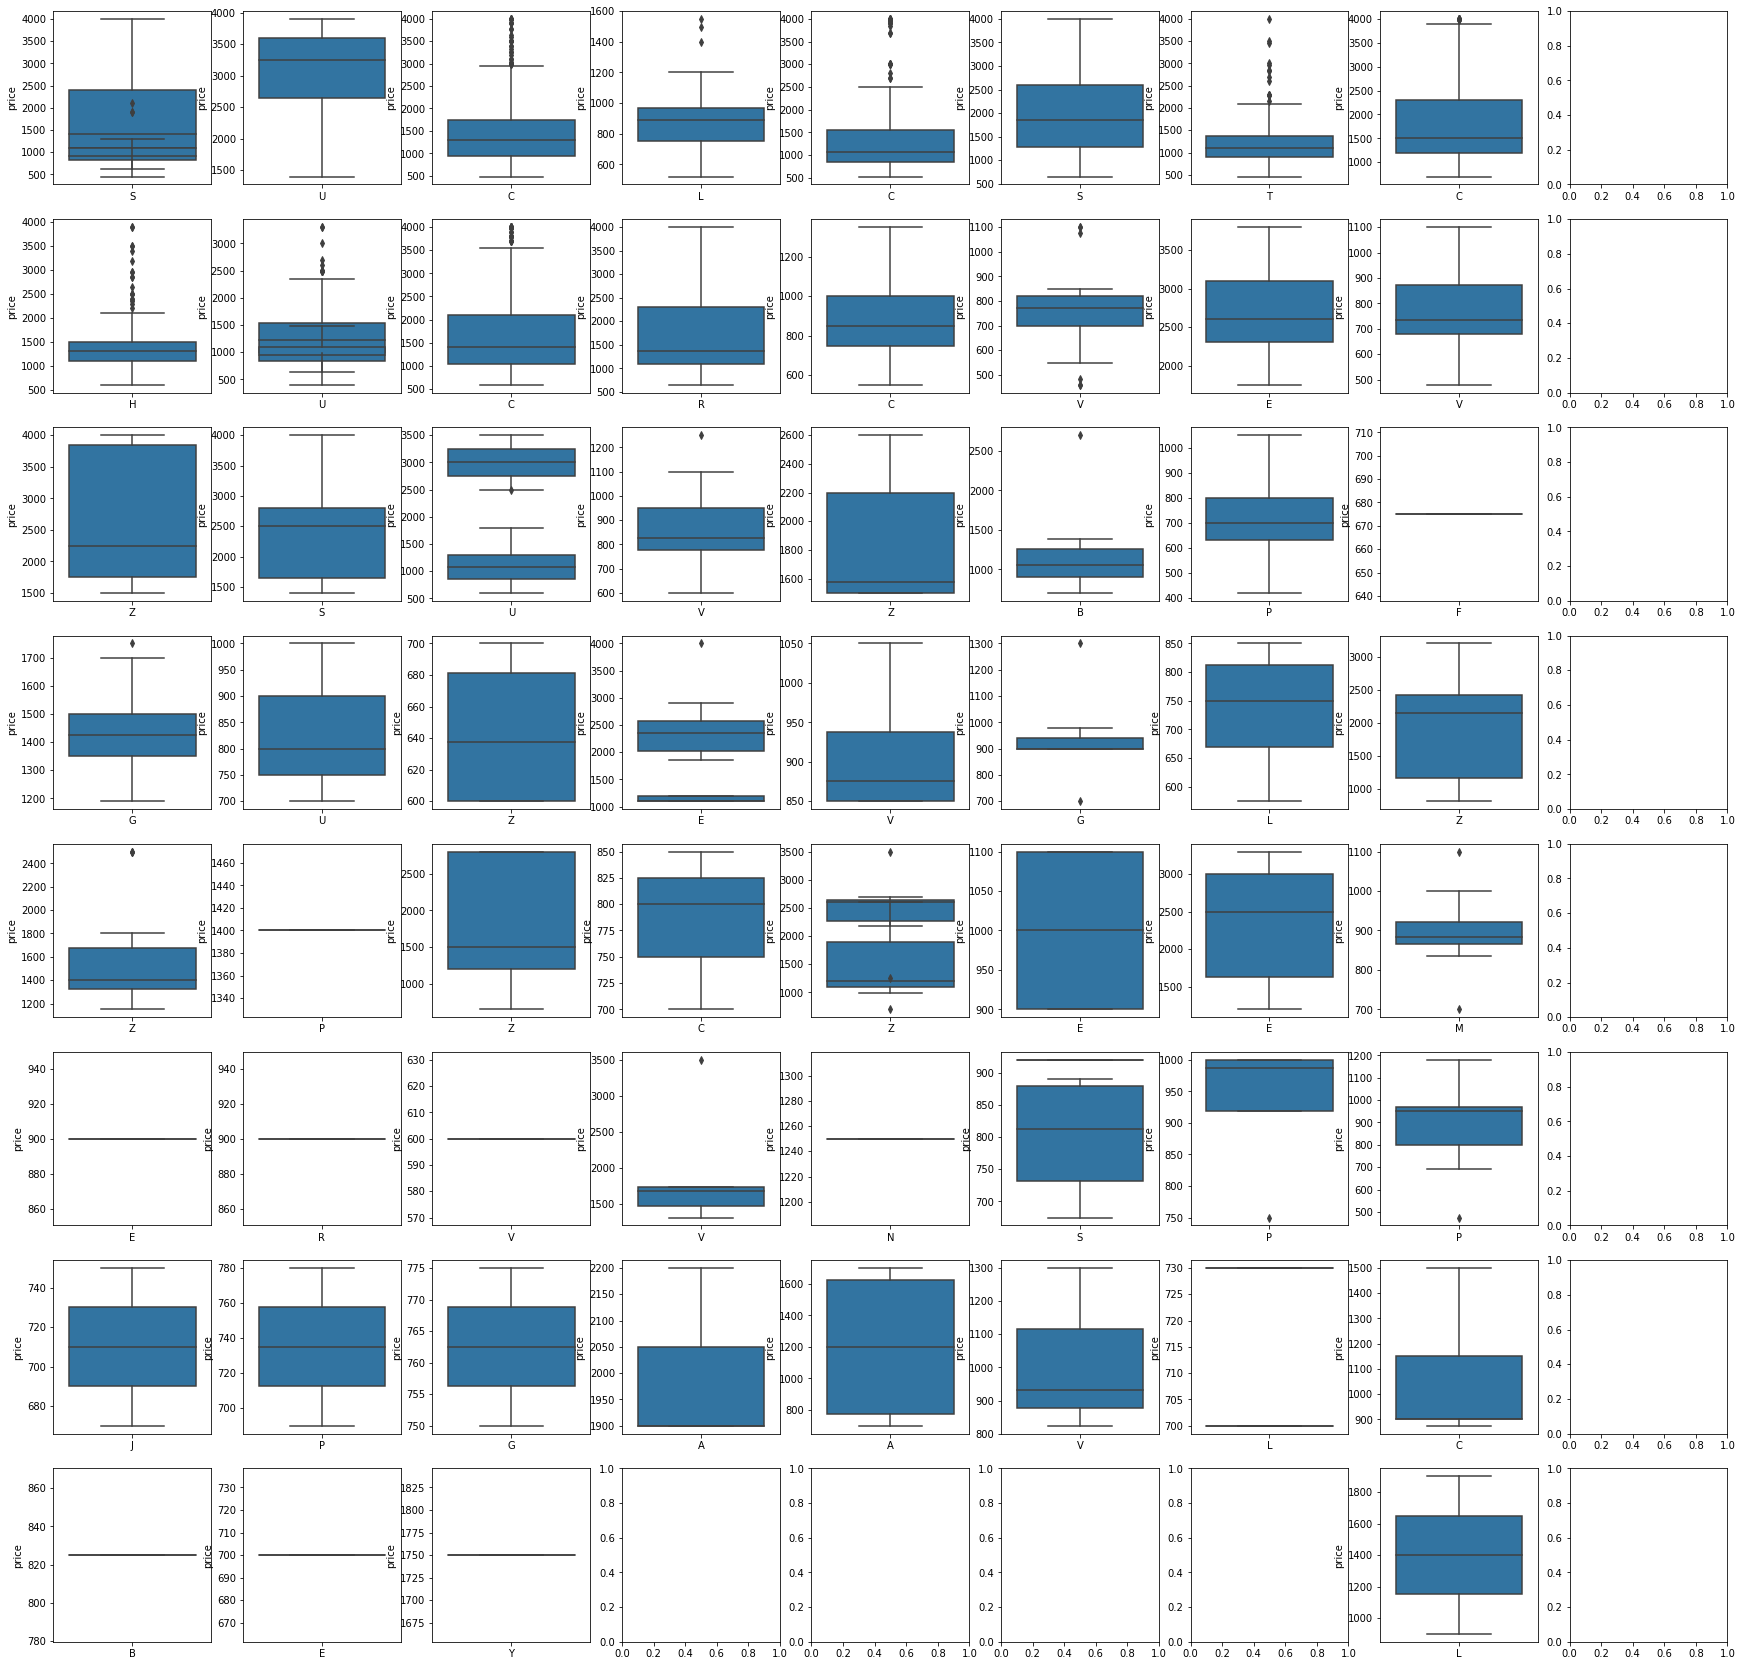

In [69]:
fig, ax = plt.subplots(8,9, figsize=(30,30))
for i, district in enumerate(df['district'].unique()):
    row = i // 9
    col = i % 8
    g =sns.boxplot(y='price', data=df[df['district'] == district], ax = ax[row, col])
    g.set_xticklabels(district)

We can also see that there is a big difference between the prices of the different districts. So we will have to take  
theser into accoutn as well for our model

In [72]:
df['numPhotos'].describe()

count    4148.000000
mean       22.273867
std        11.602292
min         0.000000
25%        14.000000
50%        21.000000
75%        28.000000
max        94.000000
Name: numPhotos, dtype: float64

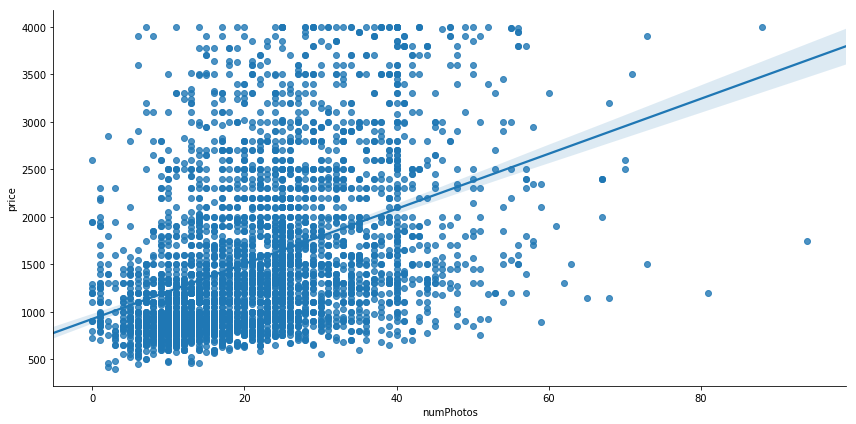

In [86]:
sns.lmplot('numPhotos', 'price', data=df, height=6,aspect=2)

There seems to be a positive correlation between the num of photos ina  listing and its price.  
This could be because the more expensive listincs probably use real estate agent, and to increase  
exposure they have more pictures. But this could be a spurrious correlation

### Model Building 

In [87]:
from statsmodels.regression.linear_model import OLS

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4148 entries, 0 to 4147
Data columns (total 24 columns):
bathrooms                4148 non-null int64
detailedType_typology    4148 non-null object
distance                 4148 non-null int64
district                 4148 non-null object
exterior                 4148 non-null bool
floor                    4148 non-null int64
has360                   4148 non-null bool
has3DTour                4148 non-null bool
hasLift                  4148 non-null bool
hasPlan                  4148 non-null bool
hasVideo                 4148 non-null bool
latitude                 4148 non-null float64
longitude                4148 non-null float64
municipality             4148 non-null object
numPhotos                4148 non-null int64
hasParkingSpace          4148 non-null bool
price                    4148 non-null float64
priceByArea              4148 non-null float64
propertyCode             4148 non-null float64
propertyType             4148 no

We know that we have the most logical correlations between price, size, rooms and bathrooms. But there  
might alos be a relacion between each other so we will build the model with these to check their  
significance 

In [89]:
feats = df[['size','rooms','bathrooms']]

In [91]:
from sklearn.preprocessing import StandardScaler

In [92]:
scaler = StandardScaler()

In [93]:
feats = scaler.fit_transform(feats)

In [94]:
target = df['price']

In [101]:
model = OLS(target,feats)
results = model.fit()

In [102]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     211.3
Date:                Sat, 22 Dec 2018   Prob (F-statistic):          1.45e-127
Time:                        21:55:52   Log-Likelihood:                -36610.
No. Observations:                4148   AIC:                         7.323e+04
Df Residuals:                    4145   BIC:                         7.324e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           451.2024     50.958      8.854      0.000     351.297     551.108
x2           -16.9535     41.566     -0.408      0.683     -98.445      64.539
x3           231.9675     48.523      4.781      0.000     136.837     327.098
==============================================================================
Omnibus:                      848.079   Durbin-Watson:                   0.145
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2669.183
Skew:                           1.036   Prob(JB):                         0.00
Kurtosis:                       6.340   Cond. No.                         3.98
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Seems like number of rooms is not significant. So we will drop that variable

In [103]:
feats = scaler.fit_transform(df[['size','bathrooms']])

In [104]:
model = OLS(target,feats)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     317.0
Date:                Sat, 22 Dec 2018   Prob (F-statistic):          7.81e-129
Time:                        21:57:12   Log-Likelihood:                -36610.
No. Observations:                4148   AIC:                         7.322e+04
Df Residuals:                    4146   BIC:                         7.324e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           442.7951     46.599      9.502      0.000     351.437     534.153
x2           226.4561     46.599      4.860      0.000     135.098     317.814
==============================================================================
Omnibus:                      849.587   Durbin-Watson:                   0.145
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2645.969
Skew:                           1.041   Prob(JB):                         0.00
Kurtosis:                       6.313   Cond. No.                         3.34
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Seems like they are both significant, but we're getting a low R^2 so we'll try to add some more variables

In [105]:
feats = scaler.fit_transform(df[['size','bathrooms','distance']])
model = OLS(target,feats)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     240.3
Date:                Sat, 22 Dec 2018   Prob (F-statistic):          9.56e-144
Time:                        21:58:15   Log-Likelihood:                -36572.
No. Observations:                4148   AIC:                         7.315e+04
Df Residuals:                    4145   BIC:                         7.317e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           459.7384     46.227      9.945      0.000     369.109     550.368
x2           265.6544     46.406      5.725      0.000     174.675     356.634
x3          -226.8416     26.112     -8.687      0.000    -278.036    -175.647
==============================================================================
Omnibus:                      866.312   Durbin-Watson:                   0.122
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2904.474
Skew:                           1.037   Prob(JB):                         0.00
Kurtosis:                       6.537   Cond. No.                         3.44
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As we set the distance as the center of Madrid, it seems like being far from the center has a negative  
effect on the rental price. This could probably be used better with the districts but we won't use them yet

In [106]:
feats = scaler.fit_transform(df[['size','bathrooms','distance', 'numPhotos']])
model = OLS(target,feats)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     183.1
Date:                Sat, 22 Dec 2018   Prob (F-statistic):          1.20e-144
Time:                        22:00:01   Log-Likelihood:                -36567.
No. Observations:                4148   AIC:                         7.314e+04
Df Residuals:                    4144   BIC:                         7.317e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           436.1824     46.785      9.323      0.000     344.459     527.906
x2           253.0694     46.530      5.439      0.000     161.846     344.292
x3          -221.5733     26.139     -8.477      0.000    -272.819    -170.327
x4            86.3701     27.544      3.136      0.002      32.369     140.371
==============================================================================
Omnibus:                      912.535   Durbin-Watson:                   0.121
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3054.301
Skew:                           1.092   Prob(JB):                         0.00
Kurtosis:                       6.592   Cond. No.                         3.64
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

So far all our chosen features are significant in their relationship with the target variable 'price'  
but we're still only explaining 15% of the variance in y. 
Some possible correlations to price can be if the place is exterior or not, if it has a lift, if it has a parking spot  
and the floor the apartment is on. So we will aggregate all those to our model

In [109]:
feats = scaler.fit_transform(df[['size','bathrooms','distance', 'numPhotos',
                                 'hasParkingSpace', 'exterior', 'floor','hasLift']])
model = OLS(target,feats,)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     93.86
Date:                Sat, 22 Dec 2018   Prob (F-statistic):          7.74e-144
Time:                        22:41:16   Log-Likelihood:                -36559.
No. Observations:                4148   AIC:                         7.313e+04
Df Residuals:                    4140   BIC:                         7.318e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           448.5607     47.283      9.487      0.000     355.862     541.260
x2           240.4219     47.009      5.114      0.000     148.259     332.585
x3          -230.3370     29.263     -7.871      0.000    -287.708    -172.966
x4            73.1808     27.729      2.639      0.008      18.817     127.544
x5            19.1471     30.947      0.619      0.536     -41.526      79.820
x6            39.6426     26.653      1.487      0.137     -12.612      91.897
x7             4.8519     26.613      0.182      0.855     -47.324      57.028
x8            79.9169     27.387      2.918      0.004      26.225     133.609
==============================================================================
Omnibus:                      999.514   Durbin-Watson:                   0.115
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3196.133
Skew:                           1.212   Prob(JB):                         0.00
Kurtosis:                       6.551   Cond. No.                         3.95
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Seems like having a parking space, being exterior and which floor they're on are not significant.  
We check the reponse to floor as it might be a non linear relationship

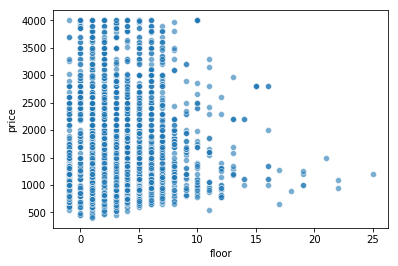

In [112]:
sns.scatterplot('floor', 'price', data=df, alpha=0.6)

There seems to be almost no relationship

In [114]:
feats = scaler.fit_transform(df[['size','bathrooms','distance', 'numPhotos',
                                 'hasLift']])
model = OLS(target,feats,)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     149.6
Date:                Sat, 22 Dec 2018   Prob (F-statistic):          2.00e-146
Time:                        22:45:08   Log-Likelihood:                -36560.
No. Observations:                4148   AIC:                         7.313e+04
Df Residuals:                    4143   BIC:                         7.316e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           452.0322     46.911      9.636      0.000     360.062     544.003
x2           241.8610     46.558      5.195      0.000     150.582     333.140
x3          -218.4972     26.112     -8.368      0.000    -269.691    -167.303
x4            77.1545     27.615      2.794      0.005      23.013     131.296
x5            94.0462     25.495      3.689      0.000      44.063     144.030
==============================================================================
Omnibus:                      984.412   Durbin-Watson:                   0.116
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3159.656
Skew:                           1.193   Prob(JB):                         0.00
Kurtosis:                       6.548   Cond. No.                         3.65
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We're back to 100% significance, but we need to test the other boolean values for their correlation  
has360        
has3DTour   
hasLift   
hasPlan 
hasVideo

In [117]:
feats = scaler.fit_transform(df[['size','bathrooms','distance', 'numPhotos',
                                 'hasLift', 'has360','has3DTour', 'hasLift',
                                'hasPlan', 'hasVideo']])
model = OLS(target,feats,)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     84.69
Date:                Sat, 22 Dec 2018   Prob (F-statistic):          6.24e-145
Time:                        22:52:15   Log-Likelihood:                -36554.
No. Observations:                4148   AIC:                         7.313e+04
Df Residuals:                    4139   BIC:                         7.318e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           444.0775     46.931      9.462      0.000     352.067     536.088
x2           236.3259     46.548      5.077      0.000     145.067     327.585
x3          -205.9304     26.471     -7.780      0.000    -257.827    -154.033
x4            60.1334     28.445      2.114      0.035       4.365     115.902
x5            45.5612     12.744      3.575      0.000      20.576      70.546
x6            66.6015     25.607      2.601      0.009      16.398     116.805
x7             2.7749     25.535      0.109      0.913     -47.287      52.837
x8            45.5612     12.744      3.575      0.000      20.576      70.546
x9            62.7697     31.462      1.995      0.046       1.086     124.453
x10          -11.3108     29.729     -0.380      0.704     -69.595      46.974
==============================================================================
Omnibus:                      834.288   Durbin-Watson:                   0.117
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2433.558
Skew:                           1.045   Prob(JB):                         0.00
Kurtosis:                       6.117   Cond. No.                     7.82e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.59e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

We see a couple of non-significant variables so we take them out 

In [124]:
feats = scaler.fit_transform(df[['size','bathrooms','distance', 'numPhotos',
                                 'hasLift', 'has360', 'hasLift',
                                'hasPlan']])
model = OLS(target,feats,)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     108.9
Date:                Sat, 22 Dec 2018   Prob (F-statistic):          6.20e-147
Time:                        22:54:49   Log-Likelihood:                -36554.
No. Observations:                4148   AIC:                         7.312e+04
Df Residuals:                    4141   BIC:                         7.317e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           444.2716     46.911      9.471      0.000     352.302     536.242
x2           236.1096     46.535      5.074      0.000     144.877     327.343
x3          -205.4303     26.434     -7.771      0.000    -257.255    -153.605
x4            60.4636     28.413      2.128      0.033       4.758     116.169
x5            45.5513     12.741      3.575      0.000      20.573      70.530
x6            67.4951     25.492      2.648      0.008      17.518     117.473
x7            45.5513     12.741      3.575      0.000      20.573      70.530
x8            57.0541     27.045      2.110      0.035       4.032     110.077
==============================================================================
Omnibus:                      838.014   Durbin-Watson:                   0.117
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2441.811
Skew:                           1.049   Prob(JB):                         0.00
Kurtosis:                       6.118   Cond. No.                     7.76e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.57e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

There seems to be significant in general, but we're still getting the 15 R2 meaning that  
we're not explaining a lot of the Y variance with our X.  
This could mean that the largest explanation is in the categorical variables

### Variable Importances

One method we can use to find variable importances in our dataset is using a different model  
In this case we can use Random Forest to see which variables seem most important to the price

In [159]:
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

from sklearn.model_selection import train_test_split

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4148 entries, 0 to 4147
Data columns (total 24 columns):
bathrooms                4148 non-null int64
detailedType_typology    4148 non-null object
distance                 4148 non-null int64
district                 4148 non-null object
exterior                 4148 non-null bool
floor                    4148 non-null int64
has360                   4148 non-null bool
has3DTour                4148 non-null bool
hasLift                  4148 non-null bool
hasPlan                  4148 non-null bool
hasVideo                 4148 non-null bool
latitude                 4148 non-null float64
longitude                4148 non-null float64
municipality             4148 non-null object
numPhotos                4148 non-null int64
hasParkingSpace          4148 non-null bool
price                    4148 non-null float64
priceByArea              4148 non-null float64
propertyCode             4148 non-null float64
propertyType             4148 no

In [126]:
feats = df.columns

In [194]:
X = df.copy()

In [195]:
X.columns

Index(['bathrooms', 'detailedType_typology', 'distance', 'district',
       'exterior', 'floor', 'has360', 'has3DTour', 'hasLift', 'hasPlan',
       'hasVideo', 'latitude', 'longitude', 'municipality', 'numPhotos',
       'hasParkingSpace', 'price', 'priceByArea', 'propertyCode',
       'propertyType', 'rooms', 'showAddress', 'size', 'status'],
      dtype='object')

In [196]:
X.drop(['latitude','longitude','price','priceByArea','propertyCode','detailedType_typology', 'showAddress'], axis=1, inplace=True)

In [153]:
y = df['price']

In [197]:
X = pd.get_dummies(X)

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.32, random_state=101)

In [162]:
rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)
print("Train: ",rfr.score(X_train,y_train))
print("Test: ",rfr.score(X_test,y_test))

Train:  0.9651517481891312
Test:  0.8290800242277729


In [161]:
gbr = GradientBoostingRegressor(n_estimators=200)
gbr.fit(X_train,y_train)
print("Train: ",gbr.score(X_train,y_train))
print("Test: ",gbr.score(X_test,y_test))

Train:  0.8760118547910274
Test:  0.8446767651624798


In [166]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols': df.columns,'imp' :
    m.feature_importances_}).sort_values('imp',ascending = False)

In [167]:
fi = rf_feat_importance(rfr, X)
fi[:10]

,cols,imp
12,size,0.684596
1,distance,0.115815
9,numPhotos,0.041142
0,bathrooms,0.028986
3,floor,0.021540
4,has360,0.012062
7,hasPlan,0.011795
54,district_Salamanca,0.011428
11,rooms,0.010786
21,district_Chamartín,0.007974


In [168]:
fi = rf_feat_importance(gbr, X)
fi[:10]

,cols,imp
12,size,0.726602
1,distance,0.113933
0,bathrooms,0.057397
9,numPhotos,0.019247
54,district_Salamanca,0.012516
7,hasPlan,0.012164
4,has360,0.009536
21,district_Chamartín,0.008145
11,rooms,0.005917
85,municipality_La Moraleja,0.003539


From these experiments, we can see that size seems to be the most important metric for this algorithm.  
Same with distance, bathroom, num Photos, but then Districts start appearing. 

We'll run the Linear Model with the dummy variables for district.However at this point the number of features  
has exploded so we might not be able to interpret the model that easily

### Back to Linear Model

In [170]:
feats = scaler.fit_transform(X)
model = OLS(target,feats)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     9.425
Date:                Sat, 22 Dec 2018   Prob (F-statistic):          5.60e-107
Time:                        23:14:36   Log-Likelihood:                -36523.
No. Observations:                4148   AIC:                         7.322e+04
Df Residuals:                    4061   BIC:                         7.377e+04
Df Model:                          87                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           205.4592     51.061      4.024      0.000     105.351     305.567
x2          -221.5089     82.686     -2.679      0.007    -383.619     -59.399
x3            41.8133     29.226      1.431      0.153     -15.486      99.113
x4            -2.2624     28.180     -0.080      0.936     -57.511      52.986
x5            60.9989     25.859      2.359      0.018      10.302     111.696
x6            -5.7410     25.814     -0.222      0.824     -56.351      44.869
x7            37.3628     30.641      1.219      0.223     -22.710      97.435
x8            59.8899     31.918      1.876      0.061      -2.686     122.466
x9           -23.7765     30.235     -0.786      0.432     -83.054      35.501
x10           47.2773     29.019      1.629      0.103      -9.616     104.171
x11           46.5078     32.931      1.412      0.158     -18.055     111.071
x12           44.6386     48.942      0.912      0.362     -51.314     140.591
x13          419.6552     57.875      7.251      0.000     306.189     533.122
x14            8.1160     22.397      0.362      0.717     -35.795      52.027
x15          -48.1808     25.985     -1.854      0.064     -99.126       2.765
x16           -5.6804     24.995     -0.227      0.820     -54.684      43.323
x17            0.4391     28.448      0.015      0.988     -55.335      56.213
x18            4.5490     24.997      0.182      0.856     -44.458      53.556
x19          -48.1944     25.156     -1.916      0.055     -97.514       1.125
x20            4.4471     33.557      0.133      0.895     -61.343      70.237
x21          -17.2766     36.548     -0.473      0.636     -88.930      54.377
x22           35.9604     23.917      1.504      0.133     -10.929      82.850
x23           24.1234     26.916      0.896      0.370     -28.647      76.894
x24          -31.0594     25.758     -1.206      0.228     -81.559      19.440
x25           -3.0022     16.967     -0.177      0.860     -36.267      30.263
x26            1.7570     21.968      0.080      0.936     -41.311      44.825
x27          -11.9293     23.948     -0.498      0.618     -58.880      35.021
x28           -5.0973     31.070     -0.164      0.870     -66.012      55.818
x29           -4.1945     21.931     -0.191      0.848     -47.191      38.802
x30           25.6593     22.776      1.127      0.260     -18.994      70.313
x31           29.5640     18.618      1.588      0.112      -6.937      66.065
x32           -6.1367     21.580     -0.284      0.776     -48.445      36.171
x33          -19.1467     32.373     -0.591      0.554     -82.616      44.323
x34            0.7062     12.845      0.055      0.956     -24.476      25.889
x35            2.7233     22.512      0.121      0.904     -41.413      46.860
x36           -6.6724     24.531     -0.272      0.786     -54.767      41.422
x3

In [180]:
for i, col in enumerate(X.columns):
    if col == 'district_Salamanca':
        print(i)

54


We can see that we have a lot of districts that are not significant at all, but at the same time some districts seem to be very significant like being ins Salamanca (feature 55) has an almost 100 Euro premium in rent with almost 0 p-value

### Conclusions

We have concluded that as we suspected. The size of the apartment, the ammount of rooms, bathrooms are positively  
correlated to the price of rent, and are also very significant to it. The district is alos important, although  
some districts like Salamanca command a premium while others are less significant. This is logical  
as some districts won't affect the price as they are not special. That's why those dummy variables seem unimportant.

As we care more about the predictive power of our model, than the inference we get from it.  We will swith to using  
sklearns Linear Models to try and get a better model with a higher R^2 to implement.

## Machine Learning

In [183]:
from sklearn.linear_model import Lasso, Ridge, LinearRegression

In [187]:
X2 = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.3, random_state=101)

In [188]:
m1 = LinearRegression()
m1.fit(X_train, y_train)
print("Train: ", m1.score(X_train, y_train))
print("Test: ", m1.score(X_test, y_test))

Train:  0.786660537558906
Test:  -5.849476790004094e+26


Well that is weird, this could be because off all the insignificant and dummy variables. We can add some regularization to our model  
We can start with L2 regularization with Ridge Regression, and if it's not enough we can go for L1 reg with LASSO

In [191]:
m2 = Ridge()
m2.fit(X_train, y_train)
print("Train: ", m2.score(X_train, y_train))
print("Test: ", m2.score(X_test, y_test))

m2_coef = pd.DataFrame(m2.coef_, index=X.columns, columns=['coef'])

Train:  0.7884826245934231
Test:  0.7929662322250918


This seems much better.  We can also check the coefficients

In [207]:
m2_coef[m2_coef['coef'] > 10].sort_values(by='coef', ascending = False)

,coef
size,399.740743
bathrooms,213.527895
district_Salamanca,88.064063
hasPlan,70.350010
has360,54.542340
rooms,52.904398
numPhotos,43.116144
hasParkingSpace,42.934122
hasLift,41.747064
municipality_La Moraleja,37.461836


These coefficients are all from a Scaled Variable, that's why Size seems too big. This can only be interpreted  
as biggest price "movers"

In [208]:
m3 = Lasso()
m3.fit(X_train, y_train)
print("Train: ", m3.score(X_train, y_train))
print("Test: ", m3.score(X_test, y_test))

m3_coef = pd.DataFrame(m3.coef_, index=X.columns, columns=['coef'])

Train:  0.7883007135327403
Test:  0.794321359881087


In [210]:
m3_coef[m3_coef['coef'] > 10].sort_values(by='coef', ascending = False)

,coef
size,401.092479
bathrooms,212.619603
district_Salamanca,100.110465
municipality_La Moraleja,79.810637
hasPlan,68.954368
has360,53.861210
rooms,51.793921
district_Chamartín,43.269687
numPhotos,42.832062
hasLift,42.246458


In [215]:
print(sum(m3_coef['coef'] > 0), "coefficients not made '0' by model")

40 coefficients not made '0' by model


The LASSO model made 60 coefficients 0, reducing the chances of the model being wrong because of insignificant variables

In [217]:
print("LinReg Score: ", m1.score(X_test, y_test))
print("Ridge Score: ", m2.score(X_test, y_test))
print("Lasso Score: ", m3.score(X_test, y_test))

LinReg Score:  -5.849476790004094e+26
Ridge Score:  0.7929662322250918
Lasso Score:  0.794321359881087


As Lasso Uses less variables and gave us marginally a better score, wwe can then optimize for this one

In [245]:
loss_values = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10]
train_score = []
test_score = []

for i in loss_values:
    m = Lasso(alpha=i)
    m.fit(X_train, y_train)
    train_score.append(m.score(X_train, y_train))
    test_score.append(m.score(X_test, y_test))

models_list = pd.DataFrame(data={'Loss':loss_values, 'Train':train_score, 'Test': test_score})
models_list

,Loss,Train,Test
0,0.000001,0.788483,0.793486
1,0.000010,0.788483,0.793486
2,0.000100,0.788483,0.793481
3,0.001000,0.788483,0.793414
4,0.010000,0.788483,0.793293
5,0.100000,0.788481,0.792966
6,1.000000,0.788301,0.794321
7,10.000000,0.780804,0.790248


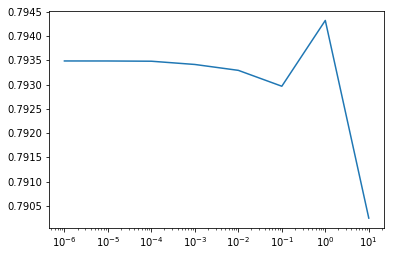

In [253]:
plt.plot(models_list['Loss'], models_list['Test'])
plt.xscale('log')

Seems like the best linear model for this dataset is the Lasso Regression algorithm with an alpha of 1 (default)

# Final Conclusions

We found what the main drivers for the price is, and we found that in the case of districts, only some were important and not the other ones.  We also had to decide between interpretability getting 15% explained variance in Y with that set. Compared with Predictions power which using sklearn's linear methods got close to 80% in R squared. 

As next steps, we will reproduce this model in Dataiku so that we can use the flow to create a train/val/test dataset. And then  create some new features with the model as predcited price so we can use residuals to figure out if a listing price is a good deal or not